# 使用cuSolver库进行奇异值分解和主成分分析

在本部分，我们将使用cuSolver库进行奇异值分解和主成分分析，对图像进行重构。

In [2]:
import pycuda.autoinit
from pycuda import gpuarray
import numpy as np
from skcuda import linalg
import skcuda
from PIL import Image
import matplotlib.pyplot as plt
import tifffile as tiff
import cupy as cp
import time
skcuda.misc.init()

定义SVD和PCA操作

In [8]:
def SVD(a):
    
    # 将输入矩阵转换为32位浮点数类型
    a = a.astype(np.float32)
    # 将矩阵上传到GPU内存
    a_gpu = gpuarray.to_gpu(a)
    # 在GPU上使用cusolver库执行SVD分解，返回U, s, V矩阵的GPU数组
    U_d, s_d, V_d = linalg.svd(a_gpu, lib='cusolver')
    # 将分解后的U矩阵从GPU下载到主机内存
    U = U_d.get()
    # 将奇异值向量s从GPU下载到主机内存
    s = s_d.get()
    # 将V矩阵从GPU下载到主机内存
    V = V_d.get()
    
    # 返回分解后的U, s, V矩阵
    return U, s, V

In [3]:
def PCA_cuSolver(image, k):
   
    start = time.time() 
    # 将图像数据转换为64位浮点数类型
    image = image.astype(np.float64)
    # 计算图像每列的平均值，用于数据中心化
    mean = np.mean(image, axis=0)
    # 对图像进行中心化处理，即减去平均值
    image_centered = image - mean
    # 将图像数据传输到 GPU
    image_gpu = gpuarray.to_gpu(image_centered)
    # 执行 GPU 加速的 SVD 分解
    U_gpu, s_gpu, V_gpu = linalg.svd(image_gpu, lib='cusolver')
    # 将 GPU 数据传回 CPU
    U = U_gpu.get()
    s = s_gpu.get()
    V = V_gpu.get()
    # 选择前k个左奇异向量，构成U_k矩阵
    U_k = U[:, :k]
    # 选择前k个奇异值，构成s_k向量
    s_k = s[:k]
    # 选择前k个右奇异向量，构成V_k矩阵
    V_k = V[:k, :]
    # 构造对角矩阵S_k，其中对角线元素为s_k中的奇异值
    S_k = np.diag(s_k)
    # 使用前k个主成分重构图像，并加上平均值恢复原始尺度
    image_pca = np.dot(U_k, np.dot(S_k, V_k)) + mean
    end = time.time()
    duration = end - start
    print(f"重构图片耗时:{duration:.4f}秒")
    
    # 返回重构后的图像
    return image_pca

In [13]:
def PCA_np(image, k):

    start = time.time()
    # 数据类型转换为64位浮点数
    image = image.astype(np.float64)
    # 计算图像每列的平均值，并进行中心化
    mean = np.mean(image, axis=0)
    image_centered = image - mean
    
    # 执行SVD分解
    U, s, V = np.linalg.svd(image_centered, full_matrices=False)
    
    # 保留前k个主成分
    U_k = U[:, :k]
    s_k = s[:k]
    V_k = V[:k, :]
    
    # 重构图像
    S_k = np.diag(s_k)
    image_pca = np.dot(U_k, np.dot(S_k, V_k)) + mean
    end = time.time()
    duration = end - start
    print(f"重构图片耗时:{duration:.4f}秒")
    
    return image_pca

In [19]:
def PCA_cuPy(image, k):
    
    start = time.time()
    # 数据类型转换为 float64
    image = image.astype(np.float64)
    mean = np.mean(image, axis=0)
    image_centered = image - mean

    # 使用 cuPy 进行 SVD
    image_gpu = cp.asarray(image_centered)
    U_gpu, s_gpu, V_gpu = cp.linalg.svd(image_gpu, full_matrices=False)

    # 截断前 k 个主成分
    U_k = U_gpu[:, :k]
    s_k = s_gpu[:k]
    V_k = V_gpu[:k, :]

    # 重构图像
    S_k = cp.diag(s_k)
    image_pca_gpu = cp.dot(U_k, cp.dot(S_k, V_k)) + cp.asarray(mean)
    image_pca = cp.asnumpy(image_pca_gpu)  # 将数据传回 CPU
    end = time.time()
    duration = end - start
    print(f"重构图片耗时:{duration:.4f}秒")

    return image_pca

首先读取并合成RGB图像

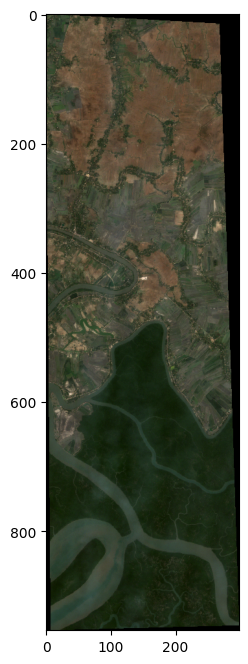

In [4]:
# 读取图像数据
def load_image(image_path):
    img = tiff.imread(image_path)[:,:,0]
    return img.astype(np.float32)

# 图像路径
red_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
green_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff"
blue_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff"

# 读取图像
red_image = load_image(red_image_path)
green_image = load_image(green_image_path)
blue_image = load_image(blue_image_path)

# 合成RGB图像
rgb_image = np.dstack((red_image, green_image, blue_image))
rgb_image_normalized = rgb_image/np.max(rgb_image)

plt.figure(figsize=(10, 8))
plt.imshow(rgb_image_normalized)

下面我们取不同的主成分数，比较不同主成分数下处理后图像的变化。同时比较cuSolver,cuPy和Numpy的处理效果和运行时长。

将RGB图像转为灰度图像，观察一下矩阵奇异值的大小，并对其进行可视化。

(954, 298)


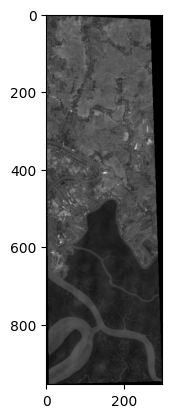

In [5]:
image = rgb_image_normalized
# 使用加权平均法将RGB图像转换为灰度图像
gray_image = 0.2989 * image[..., 0] + 0.5870 * image[..., 1] + 0.1140 * image[..., 2]

# 现在 gray_image 是形状为 (954, 298) 的灰度图像
print(gray_image.shape)
plt.imshow(gray_image,cmap="gray")
plt.savefig("gray_image.png")

In [10]:
gray_image = gray_image.T  # 进行奇异值分解前先对其进行转置，防止后续矩阵维度不匹配
U, s, V = SVD(gray_image)
S = np.diag(s)
print(S.shape)
print(s)

(298, 298)
[121.84079     15.699554    15.062801    14.243086    13.971107
  11.112514    10.803832     9.901447     9.328338     9.168324
   8.068103     7.269922     6.973995     6.6982393    6.4205375
   5.5727987    5.2888827    4.77895      4.595736     4.5027833
   4.108192     3.826642     3.7121754    3.4854667    3.3757446
   3.2599697    3.2331955    3.1916087    3.101562     3.025943
   3.006491     2.8869026    2.8061743    2.776092     2.711754
   2.6481879    2.6118827    2.517786     2.4453914    2.357865
   2.352667     2.2967982    2.2634346    2.2087538    2.1576757
   2.1047983    2.0965912    2.0851948    2.0295897    1.9899327
   1.9742262    1.9509953    1.904438     1.870039     1.8505327
   1.8369198    1.8070478    1.7886332    1.7597271    1.744529
   1.727076     1.6887803    1.660791     1.6437293    1.6332206
   1.6191624    1.5982949    1.5933843    1.5802027    1.5620836
   1.5354104    1.5234069    1.5131466    1.4796575    1.4651716
   1.4546155    1.43

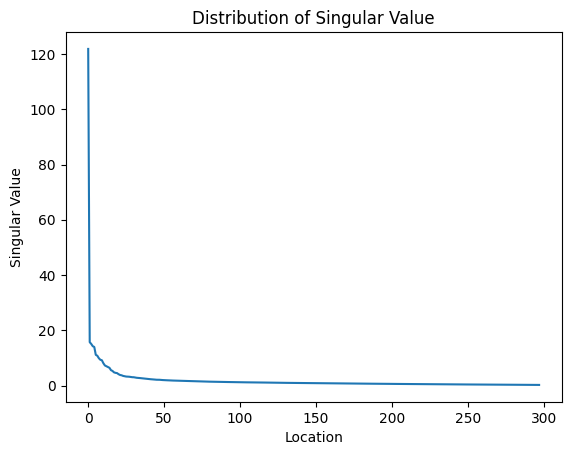

In [11]:
plt.plot(s)
plt.xlabel("Location")
plt.ylabel("Singular Value")
plt.title("Distribution of Singular Value")
plt.savefig("sigval.png")

接下来对比三种方法的处理效果和运行时长。

重构图片耗时:0.0946秒
重构图片耗时:0.0527秒
重构图片耗时:0.0530秒
重构图片耗时:0.0531秒
重构图片耗时:0.0547秒


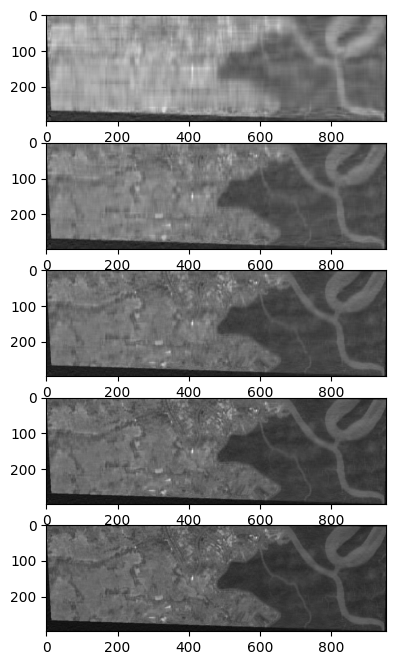

In [21]:
f, axes =  plt.subplots(5,1, figsize=(10,8)) # 设置图像
for k in range(5):
    image_PCA = PCA_np(gray_image, 10*(k+1))
    axes[k].imshow(image_PCA, cmap="gray")
plt.savefig("PCA_np.png")

重构图片耗时:0.1073秒
重构图片耗时:0.1044秒
重构图片耗时:0.1035秒
重构图片耗时:0.1037秒
重构图片耗时:0.1048秒


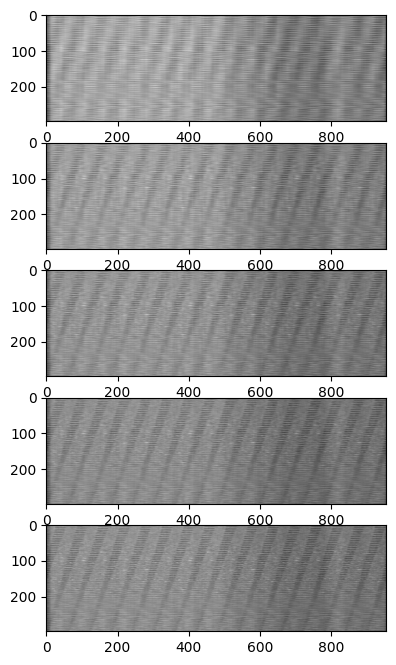

In [12]:
f, axes =  plt.subplots(5,1, figsize=(10,8)) # 设置图像
for k in range(5):
    image_PCA = PCA_cuSolver(gray_image, 10*(k+1))
    axes[k].imshow(image_PCA, cmap="gray")
plt.savefig("PCA_cuSolver.png")

重构图片耗时:0.0854秒
重构图片耗时:0.0854秒
重构图片耗时:0.0855秒
重构图片耗时:0.0866秒
重构图片耗时:0.0863秒


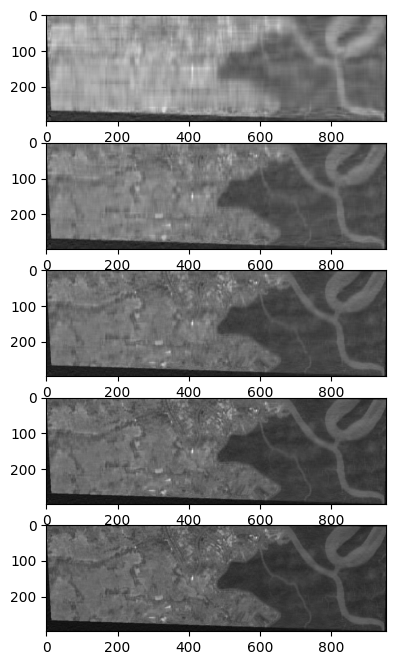

In [24]:
f, axes =  plt.subplots(5,1, figsize=(10,8)) # 设置图像
for k in range(5):
    image_PCA = PCA_cuPy(gray_image, 10*(k+1))
    axes[k].imshow(image_PCA, cmap="gray")
plt.savefig("PCA_cuPy.png")